In [6]:
%%capture
!pip install TA-Lib

In [7]:
import os
import sys
import dotenv
from time import sleep

from binance.client import Client
from binance.exceptions import BinanceAPIException

import ta
import numpy as np
import pandas as pd
import talib.abstract as talib

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn') 
%matplotlib inline

In [8]:
sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2

In [9]:
project_dir = os.path.join(os.path.dirname(os.getcwd()), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

True

In [10]:
# To create a test account visit: https://testnet.binance.vision/
USE_DEMO_ACCOUNT = False

In [11]:
if USE_DEMO_ACCOUNT:
    api_key = os.environ.get('BINANCE_API_KEY_TEST')
    api_secret = os.environ.get('BINANCE_SECRET_KEY_TEST')
    print("USE DEMO ACCOUNT!")
else:
    api_key = os.environ.get('BINANCE_API_KEY')
    api_secret = os.environ.get('BINANCE_SECRET_KEY')
    print("USE REAL ACCOUNT!")

USE REAL ACCOUNT!


In [12]:
client = Client(api_key, api_secret)

if USE_DEMO_ACCOUNT:
    client.API_URL = 'https://testnet.binance.vision/api'

In [13]:
TRADING_FEE = 0.1
TRADING_AMOUNT = 10  # 10 €

In [14]:
def eur_to_coin(coin_price, eur_amount):
    # calculate how many coins you can buy
    buy_amount = 1 / coin_price
    return eur_amount * buy_amount


In [15]:
def coin_to_eur(coin_price, coin_amount):
    return coin_price * coin_amount

In [16]:
def calculate_buy_costs(coin_buy_price, buy_amount):
    coins_to_buy = eur_to_coin(coin_buy_price, buy_amount)
    trading_costs = coin_to_eur(coin_buy_price, coins_to_buy * TRADING_FEE)
    return trading_costs

In [17]:
def calculate_sell_costs(sell_price, sell_qty):
    return (sell_price * sell_qty) * TRADING_FEE

In [18]:
def create_trades_df(buying_dates, selling_dates, buying_price, selling_price, selling_trigger=None, selling_signal=None, index=0):
    trades = pd.DataFrame(
        {
            'buying_dates': buying_dates,
            'selling_dates': selling_dates,
            'buying_price': buying_price,
            'selling_price': selling_price,
            'selling_trigger': selling_trigger,
            'selling_signal': selling_signal
        },
        index=[index] if index else None
    )

    # add the holding time per trade
    trades['selling_dates'] = pd.to_datetime(trades['selling_dates'])
    trades['buying_dates'] = pd.to_datetime(trades['buying_dates'])
    trades['holding_time'] = trades['selling_dates'] - trades['buying_dates']

    # add the profit per trade
    trades['profit'] = trades['selling_price'] - trades['buying_price']
    
    # add the trading costs per trade
    trades['holding_qty'] = eur_to_coin(trades['buying_price'], TRADING_AMOUNT)
    trades['trading_cost'] = calculate_sell_costs(trades['selling_price'], trades['holding_qty'])
    
    trades['net_profit'] = trades['profit'] - trades['trading_cost']
    
    # set a new index
    trades['index'] = trades.buying_dates
    trades.set_index('index', inplace=True)
    trades.index = pd.to_datetime(trades.index, unit='ms')

    return trades

In [19]:
def calculate_profits(trades):

    # => WATCH: https://www.youtube.com/watch?v=fWHQwqT3lNY&list=WL&index=3&ab_channel=Algovibes

    try:
        profits = sum(trades['profit'].values)

        net_profit = sum(trades['net_profit'].values)

        rel_profits = (net_profit / trades['buying_price'].values).mean()

        cum_return = (rel_profits+1).cumprod()[-1]

        winning_rate = len(
            [i for i in trades['net_profit'].values if i > 0]) / trades.shape[0]

        mean_holding_time = trades.holding_time.mean()

        # profit over last 30 days

        profit_df = pd.DataFrame(
            {
                'profits': profits,
                'net_profit': net_profit,
                'rel_profits': rel_profits,
                'cum_return': cum_return,
                'winning_rate': winning_rate,
                'mean_holding_time': mean_holding_time
            }, index=[0]
        )

        return profit_df.head(1)
    except Exception:
        pass

In [20]:
def get_minute_data(symbol, start_str):
    try:
        df = pd.DataFrame(client.get_historical_klines(
            symbol, "1m", start_str))
    except BinanceAPIException as e:
        print(e)
        sleep(60)
        df = pd.DataFrame(client.get_historical_klines(
            symbol, "1m", start_str))

    df = df.iloc[:, :6]
    df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    df = df.set_index('Time')
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.astype(float)

    return df

In [21]:
if os.path.exists("/workspaces/Stock-Trading/data/BTCUSDT-120days-M.csv"):
    df = pd.read_csv("/workspaces/Stock-Trading/data/BTCUSDT-120days-M.csv")
    df = df.set_index('Time')
else:
    symbol = 'BTCUSDT'
    lockback_window = '120 day ago'
    df = get_minute_data(symbol, lockback_window)
    df.to_csv("/workspaces/Stock-Trading/data/BTCUSDT-120days-M.csv")

In [22]:
raw_df = pd.read_csv(
    "/workspaces/Stock-Trading/data/BTCUSDT-120days-M.csv")
raw_df = raw_df.set_index('Time')

In [23]:
df.tail()

,Open,High,Low,Close,Volume
Time,,,,,
2022-04-11 13:50:00,41155.91,41184.00,41130.29,41149.95,144.33025
2022-04-11 13:51:00,41149.95,41154.33,41067.07,41082.68,76.66296
2022-04-11 13:52:00,41082.67,41119.11,41052.46,41107.12,65.85508
2022-04-11 13:53:00,41107.11,41144.77,41095.55,41135.13,164.63229
2022-04-11 13:54:00,41135.13,41146.81,41135.13,41146.80,3.42306


In [24]:
df.shape

(172805, 5)

# Apply Technicals

In [25]:
%%capture
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

In [26]:
df.head(2)

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Time,,,,,,,,,,,,,,,,,,,,,
2021-12-12 13:50:00,49614.11,49637.96,49606.35,49620.01,11.92196,-1.618007,11.92196,-0.135717,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49620.010000,16.217208,0.000000,0.000000
2021-12-12 13:51:00,49620.00,49620.01,49602.19,49602.20,8.63672,-10.245034,3.28524,-0.498331,-153.819983,-2.280960e+09,...,-0.002863,-0.000573,-0.002291,-2.244021,-0.448804,-1.795217,49611.924738,-0.035893,-0.035899,-0.035893


In [27]:
df.tail(2)

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Time,,,,,,,,,,,,,,,,,,,,,
2022-04-11 13:53:00,41107.11,41144.77,41095.55,41135.13,164.63229,-42804.876100,-62603.634461,0.206492,1346.730208,1.027707e+09,...,0.088539,0.039144,0.049395,9.125547,5.337354,3.788193,41068.840735,0.068139,0.068116,-17.099714
2022-04-11 13:54:00,41135.13,41146.81,41135.13,41146.80,3.42306,-42801.458901,-62600.211401,0.125825,1160.046908,7.100688e+09,...,0.096813,0.050678,0.046135,0.042617,4.278406,-4.235789,41073.631241,0.028370,0.028366,-17.076196


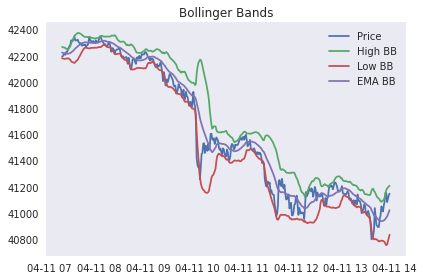

In [28]:
plt.plot(df.tail(400).Close, label='Price')
plt.plot(df.tail(400).volatility_bbh, label='High BB')
plt.plot(df.tail(400).volatility_bbl, label='Low BB')
plt.plot(df.tail(400).volatility_bbm, label='EMA BB')
plt.title('Bollinger Bands')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

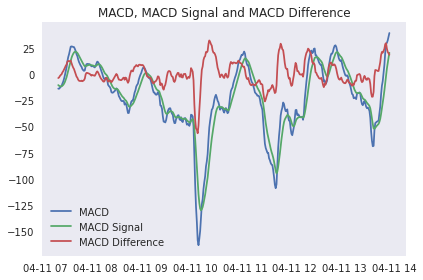

In [29]:
plt.plot(df.tail(400).trend_macd, label='MACD')
plt.plot(df.tail(400).trend_macd_signal, label='MACD Signal')
plt.plot(df.tail(400).trend_macd_diff, label='MACD Difference')
plt.title('MACD, MACD Signal and MACD Difference')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [30]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
       'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base

# Baseline
- Buy on first date
- Sell on last date

In [31]:
df.head(1)

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Time,,,,,,,,,,,,,,,,,,,,,
2021-12-12 13:50:00,49614.11,49637.96,49606.35,49620.01,11.92196,-1.618007,11.92196,-0.135717,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,49620.01,16.217208,0.0,0.0


In [32]:
trades = create_trades_df(df.iloc[0].name, df.iloc[-1].name, df.iloc[0].Open,
                          df.iloc[-1].Open, selling_trigger=None, selling_signal=None, index=True)

calculate_profits(trades)

,profits,net_profit,rel_profits,cum_return,winning_rate,mean_holding_time
0,-8478.98,-8479.809101,-0.170915,0.829085,0.0,120 days 00:04:00


In [33]:
print("Open on day 1:", df.iloc[0].Open)
print("Open on last day:", df.iloc[-1].Open)

Open on day 1: 49614.11
Open on last day: 41135.13


# Trading Strategy

In [34]:
def apply_strategy(df_input, buy_params, sell_params):

    dataframe = df_input.copy()

    dataframe = dataframe.rename(
        columns={"Open": "open", "Close": "close", "High": "high", "Low": "low", "Volume": "volume"})

    macd = talib.MACD(dataframe)
    dataframe['macd'] = macd['macd']
    dataframe['macdsignal'] = macd['macdsignal']

    # Minus Directional Indicator / Movement
    dataframe['minus_di'] = talib.MINUS_DI(dataframe)

    # RSI
    dataframe['rsi'] = talib.RSI(dataframe)

    # Inverse Fisher transform on RSI, values [-1.0, 1.0] (https://goo.gl/2JGGoy)
    rsi = 0.1 * (dataframe['rsi'] - 50)
    dataframe['fisher_rsi'] = (
        np.exp(2 * rsi) - 1) / (np.exp(2 * rsi) + 1)

    # Inverse Fisher transform on RSI normalized, value [0.0, 100.0] (https://goo.gl/2JGGoy)
    dataframe['fisher_rsi_norma'] = 50 * (dataframe['fisher_rsi'] + 1)

    # Stoch fast
    stoch_fast = talib.STOCHF(dataframe)
    dataframe['fastd'] = stoch_fast['fastd']
    dataframe['fastk'] = stoch_fast['fastk']

    # SMA - Simple Moving Average
    dataframe['sma'] = talib.SMA(dataframe, timeperiod=40)

    # Apply buying strategy
    dataframe['buy'] = np.where(
        (
            (dataframe['close'] < dataframe['sma']) &
            (dataframe['volume'] > dataframe['volume'].rolling(buy_params['buy_volumeAVG']).mean() * 4) &
            (dataframe['fastd'] > dataframe['fastk']) &
            (dataframe['rsi'] > buy_params['buy_rsi']) &
            (dataframe['fastd'] > buy_params['buy_fastd']) &
            (dataframe['fisher_rsi_norma'] < buy_params['buy_fishRsiNorma'])
        ),
        True,
        False
    )

    # Apply selling strategy
    dataframe['sell'] = np.where(
        (
        (dataframe['minus_di'] > sell_params['sell_minusDI']) &
        (dataframe['rsi'] > sell_params['sell_rsi']) &
        (dataframe['macd'] < sell_params['sell_macd'])
        ),
        True,
        False
    )

    buying_dates = []
    buying_price = []

    selling_dates = []
    selling_price = []

    selling_signal = []
    selling_trigger = []

    open_pos = False
    tsl = 0  # Trailing stop loss
    max_loss = 0.99

    for i in range(dataframe.shape[0]-1):
        # buy if we have a buy signal
        if dataframe.buy.iloc[i] and not open_pos:
            buying_dates.append(dataframe.iloc[i].name)
            buying_price.append(dataframe.iloc[i].close)
            tsl = dataframe.iloc[i].close * max_loss
            open_pos = True
        else:
            # sell the position
            if open_pos and dataframe.sell.iloc[i]:
                selling_dates.append(dataframe.iloc[i].name)
                selling_price.append(dataframe.iloc[i].close)
                selling_trigger.append("strategy")
                selling_signal.append(dataframe['rsi'].iloc[i])
                open_pos = False

            # sell the asset if the price is below our tsl
            if open_pos and (dataframe.iloc[i].close < tsl):
                selling_dates.append(dataframe.iloc[i].name)
                selling_price.append(dataframe.iloc[i].close)
                selling_trigger.append("tsl")
                selling_signal.append(tsl)
                open_pos = False
                
        # update tsl 
        if tsl < dataframe.iloc[i].close * max_loss:
            tsl = dataframe.iloc[i].close * max_loss


    # remove the most current buy if the lengths do not match
    if len(buying_dates) != len(selling_dates):
        buying_dates.pop()
        buying_price.pop()


    trades = create_trades_df(buying_dates, selling_dates,
                            buying_price, selling_price, selling_trigger, selling_signal)
    
    return trades

In [35]:
buy_params = {'buy_fastd': 4, 'buy_fishRsiNorma': 28,
              'buy_rsi': 34, 'buy_volumeAVG': 176}
sell_params = {'sell_macd': 4, 'sell_minusDI': 12, 'sell_rsi': 50}

trades = apply_strategy(raw_df.copy(), buy_params, sell_params)
profit_df = calculate_profits(trades)
profit_df

,profits,net_profit,rel_profits,cum_return,winning_rate,mean_holding_time
0,6216.79,5993.639222,0.141883,1.141883,0.780269,0 days 00:13:27.174887892


In [36]:
trades.selling_trigger.value_counts()

strategy    211
tsl          12
Name: selling_trigger, dtype: int64

array([<AxesSubplot:title={'center':'net_profit'}, xlabel='index'>],
      dtype=object)

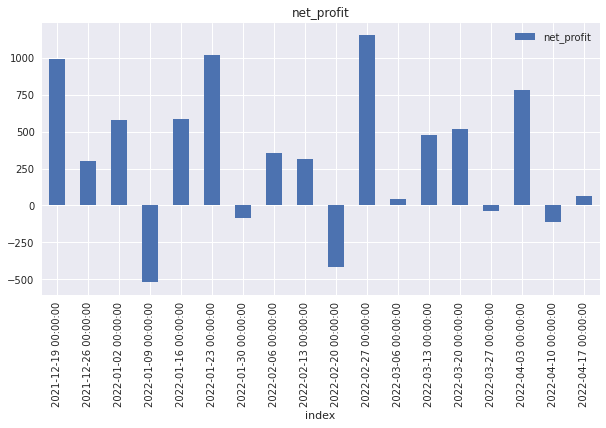

In [37]:
trades.resample('W').sum()[['net_profit']].plot(subplots=True, figsize=(10,5), kind="bar")

In [40]:
trades.sort_values('net_profit', ascending=False).head()

,buying_dates,selling_dates,buying_price,selling_price,selling_trigger,selling_signal,holding_time,profit,holding_qty,trading_cost,net_profit
index,,,,,,,,,,,
2021-12-15 19:00:00,2021-12-15 19:00:00,2021-12-15 19:15:00,47514.24,48672.73,tsl,48725.404200,0 days 00:15:00,1158.49,0.000210,1.024382,1157.465618
2022-03-28 18:24:00,2022-03-28 18:24:00,2022-03-28 19:44:00,47604.31,48056.17,strategy,51.101573,0 days 01:20:00,451.86,0.000210,1.009492,450.850508
2022-03-08 14:40:00,2022-03-08 14:40:00,2022-03-08 14:43:00,38585.35,38952.30,strategy,61.671746,0 days 00:03:00,366.95,0.000259,1.009510,365.940490
2022-02-24 14:43:00,2022-02-24 14:43:00,2022-02-24 14:48:00,35204.08,35469.58,strategy,50.239397,0 days 00:05:00,265.50,0.000284,1.007542,264.492458
2022-03-11 11:22:00,2022-03-11 11:22:00,2022-03-11 11:23:00,38834.91,39061.02,strategy,62.437215,0 days 00:01:00,226.11,0.000258,1.005822,225.104178


In [41]:
trades.sort_values('net_profit', ascending=True).head()


,buying_dates,selling_dates,buying_price,selling_price,selling_trigger,selling_signal,holding_time,profit,holding_qty,trading_cost,net_profit
index,,,,,,,,,,,
2022-01-07 13:36:00,2022-01-07 13:36:00,2022-01-07 13:38:00,42278.92,41565.22,tsl,41856.1308,0 days 00:02:00,-713.70,0.000237,0.983119,-714.683119
2022-04-02 17:59:00,2022-04-02 17:59:00,2022-04-02 18:09:00,46359.10,45682.99,tsl,45901.9143,0 days 00:10:00,-676.11,0.000216,0.985416,-677.095416
2022-04-05 23:58:00,2022-04-05 23:58:00,2022-04-06 00:18:00,45492.56,44870.01,tsl,45042.5745,0 days 00:20:00,-622.55,0.000220,0.986315,-623.536315
2021-12-13 00:54:00,2021-12-13 00:54:00,2021-12-13 01:14:00,49640.14,49116.85,tsl,49143.7386,0 days 00:20:00,-523.29,0.000201,0.989458,-524.279458
2022-02-20 05:49:00,2022-02-20 05:49:00,2022-02-20 06:12:00,39493.46,38995.83,tsl,39098.5254,0 days 00:23:00,-497.63,0.000253,0.987400,-498.617400


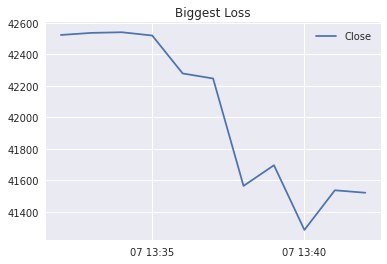

In [49]:
plt.plot(df["2022-01-07 13:32:00":"2022-01-07 13:42:00"]
         ['Close'], label='Close')

plt.title("Biggest Loss")
plt.legend()
plt.show()